In [ ]:
!pip install transformers torch

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Load dataset from JSON file
def load_json(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'pregnant.json'

intents = load_json(filename)

In [ ]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : [],
    })

    return df

df = create_df()
df

,Pattern,Tag


In [ ]:
def extract_json(json_file, df):
    for intent in json_file['intents']:
        for pattern in intent['patterns']:
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json(intents, df)
df

,Pattern,Tag
0,Hai,sapaan
1,Halo,sapaan
2,Tes,sapaan
3,"Hai, bagaimana kabarmu?",sapaan
4,"Selamat siang, saya ingin bertanya.",sapaan
...,...,...
303,Bagaimana cara menerapkan kebiasaan hidup seha...,kebiasaan_hidup_sehat
304,Apa saja kebiasaan yang perlu dihindari saat h...,kebiasaan_hidup_sehat
305,Kapan waktu yang tepat untuk beralih ke pola m...,kebiasaan_hidup_sehat
306,Bagaimana cara menjaga kesehatan fisik dan men...,kebiasaan_hidup_sehat


In [ ]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hai,sapaan
1,Halo,sapaan
2,Tes,sapaan
3,"Hai, bagaimana kabarmu?",sapaan
4,"Selamat siang, saya ingin bertanya.",sapaan


In [ ]:
def print_df_shape(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_df_shape(df, "Chatbot")

Chatbot dataset has 308 rows and 2 columns


In [ ]:
def dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 0 to 307
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  308 non-null    object
 1   Tag      308 non-null    object
dtypes: object(2)
memory usage: 7.2+ KB
None


In [ ]:
def num_classes(df, target_col, ds_name="df"):
    print(f"{ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

Chatbot dataset has 55 classes


In [ ]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('indonesian'))
df['Pattern'] = df['Pattern'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df

,Pattern,Tag
0,Hai,sapaan
1,Halo,sapaan
2,Tes,sapaan
3,"Hai, kabarmu?",sapaan
4,"Selamat siang, bertanya.",sapaan
...,...,...
303,Bagaimana menerapkan kebiasaan hidup sehat keh...,kebiasaan_hidup_sehat
304,Apa kebiasaan dihindari hamil?,kebiasaan_hidup_sehat
305,Kapan beralih pola makan sehat?,kebiasaan_hidup_sehat
306,Bagaimana menjaga kesehatan fisik mental hamil?,kebiasaan_hidup_sehat


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar kata tanya yang akan dihapus
question_words = ["apa", "apakah", "mengapa", "kenapa", "berapa", "bagaimana", "gimana", "kapan", "siapa", "dimana"]

# Fungsi untuk preprocessing
def preprocess(text):
    # Menghapus kata tanya
    words = text.split()
    filtered_words = [word for word in words if word not in question_words]
    # Menggabungkan kembali kata-kata menjadi string
    filtered_text = ' '.join(filtered_words)
    # Melakukan stemming
    stemmed_text = stemmer.stem(filtered_text)
    return stemmed_text

# Terapkan preprocessing pada kolom 'Pattern'
df['Pattern'] = df['Pattern'].apply(preprocess)

# Tampilkan DataFrame
df

,Pattern,Tag
0,hai,sapaan
1,halo,sapaan
2,tes,sapaan
3,hai kabar,sapaan
4,selamat siang tanya,sapaan
...,...,...
303,terap biasa hidup sehat hamil,kebiasaan_hidup_sehat
304,biasa hindar hamil,kebiasaan_hidup_sehat
305,alih pola makan sehat,kebiasaan_hidup_sehat
306,jaga sehat fisik mental hamil,kebiasaan_hidup_sehat


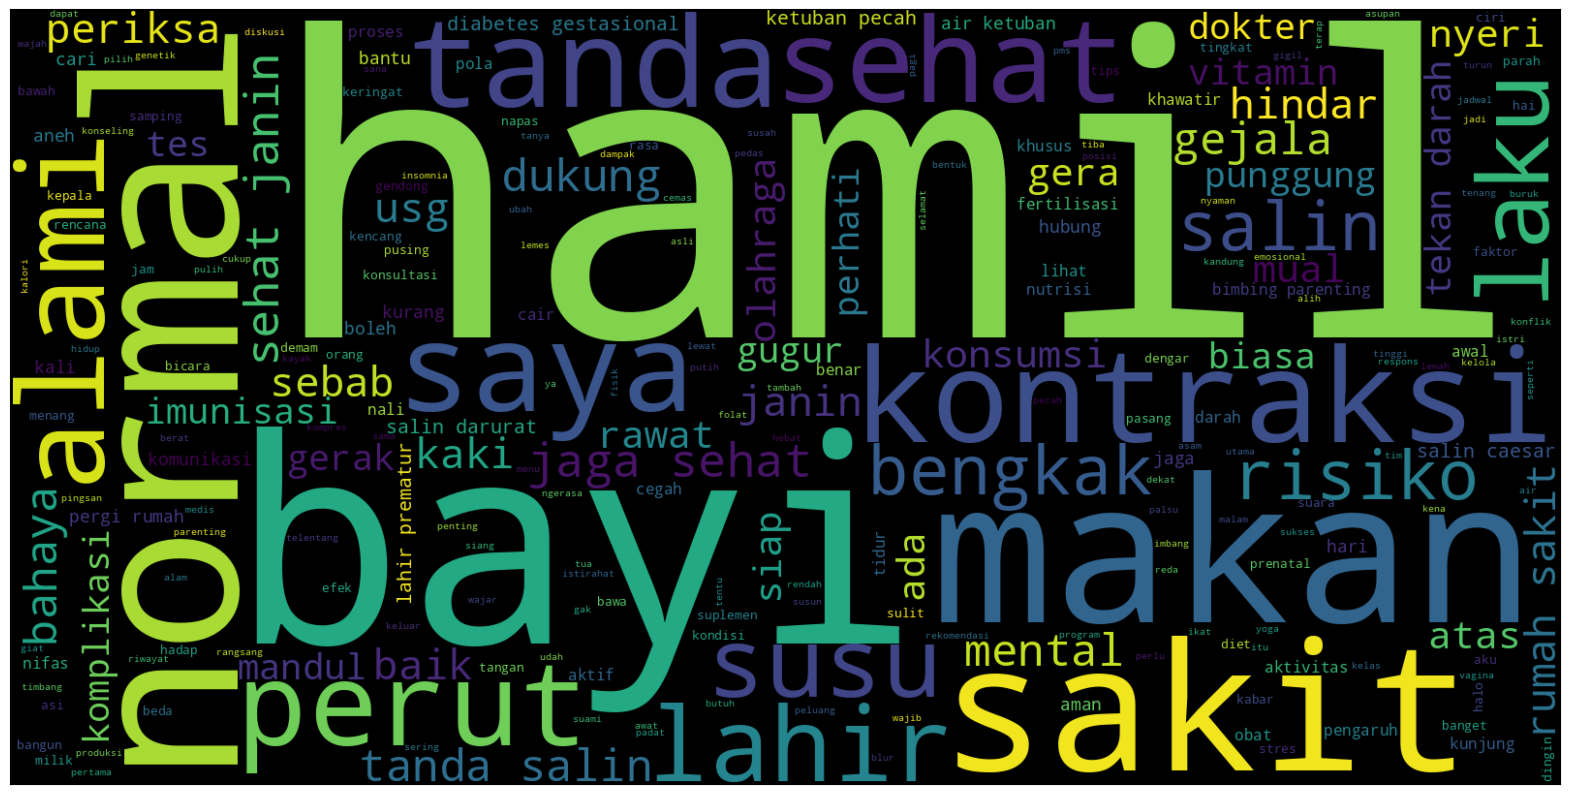

In [ ]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:20]

['hai',
 'halo',
 'tes',
 'hai',
 'kabar',
 'selamat',
 'siang',
 'tanya',
 'ada',
 'orang',
 'sana',
 'halo',
 'kabar',
 'saya',
 'alami',
 'darah',
 'berat',
 'ada',
 'nyeri',
 'hebat']

In [ ]:
print(f"dataset contains {len(corpus)} words")

dataset contains 954 words


In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'hamil': 106,
 'bayi': 39,
 'sehat': 29,
 'salin': 27,
 'sakit': 20,
 'tanda': 20,
 'normal': 19,
 'makan': 17,
 'janin': 16,
 'lahir': 16}

In [ ]:
df2.tail()

,Pattern,Tag
303,Bagaimana cara menerapkan kebiasaan hidup seha...,kebiasaan_hidup_sehat
304,Apa saja kebiasaan yang perlu dihindari saat h...,kebiasaan_hidup_sehat
305,Kapan waktu yang tepat untuk beralih ke pola m...,kebiasaan_hidup_sehat
306,Bagaimana cara menjaga kesehatan fisik dan men...,kebiasaan_hidup_sehat
307,Apa dampak dari kebiasaan buruk pada kesehatan...,kebiasaan_hidup_sehat


In [ ]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['sapaan',
 'warning',
 'mual',
 'sakit_perut',
 'kontraksi',
 'gerakan_janin',
 'perawatan_kehamilan',
 'diet_selama_hamil',
 'olahraga_selama_hamil',
 'tidur_selama_hamil',
 'kunjungan_dokter',
 'nyeri_punggung',
 'bengkak_kaki',
 'tekanan_darah',
 'diabetes_gestasional',
 'keguguran',
 'persiapan_persalinan',
 'air_ketuban',
 'gerakan_bayi',
 'pola_makan_bayi',
 'tanda_persalinan',
 'persalinan_normal',
 'persalinan_caesar',
 'perawatan_bayi',
 'pengalaman_melahirkan',
 'kontraksi_awal',
 'tanda_kehamilan',
 'pemeriksaan_kehamilan',
 'kesehatan_mental',
 'komplikasi_kehamilan',
 'persiapan_nifas',
 'menyusui',
 'imunisasi_bayi',
 'perawatan_anjing_bayi',
 'bimbingan_parenting',
 'kesehatan_janin',
 'persiapan_hamil',
 'hubungan_suami_istri',
 'kehamilan_berisiko',
 'pemeriksaan_usg',
 'kelahiran_prematur',
 'ciri_ciri_hamil',
 'tips_menyusui',
 'komunikasi_ibu_bayi',
 'seputar_fertilisasi',
 'kemandulan',
 'tips_hamil_sehat',
 'kondisi_kesehatan_ibu',
 'persalinan_darurat',
 'dukung

In [ ]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
id2label

{0: 'sapaan',
 1: 'warning',
 2: 'mual',
 3: 'sakit_perut',
 4: 'kontraksi',
 5: 'gerakan_janin',
 6: 'perawatan_kehamilan',
 7: 'diet_selama_hamil',
 8: 'olahraga_selama_hamil',
 9: 'tidur_selama_hamil',
 10: 'kunjungan_dokter',
 11: 'nyeri_punggung',
 12: 'bengkak_kaki',
 13: 'tekanan_darah',
 14: 'diabetes_gestasional',
 15: 'keguguran',
 16: 'persiapan_persalinan',
 17: 'air_ketuban',
 18: 'gerakan_bayi',
 19: 'pola_makan_bayi',
 20: 'tanda_persalinan',
 21: 'persalinan_normal',
 22: 'persalinan_caesar',
 23: 'perawatan_bayi',
 24: 'pengalaman_melahirkan',
 25: 'kontraksi_awal',
 26: 'tanda_kehamilan',
 27: 'pemeriksaan_kehamilan',
 28: 'kesehatan_mental',
 29: 'komplikasi_kehamilan',
 30: 'persiapan_nifas',
 31: 'menyusui',
 32: 'imunisasi_bayi',
 33: 'perawatan_anjing_bayi',
 34: 'bimbingan_parenting',
 35: 'kesehatan_janin',
 36: 'persiapan_hamil',
 37: 'hubungan_suami_istri',
 38: 'kehamilan_berisiko',
 39: 'pemeriksaan_usg',
 40: 'kelahiran_prematur',
 41: 'ciri_ciri_hamil',
 

In [ ]:
label2id

{'sapaan': 0,
 'warning': 1,
 'mual': 2,
 'sakit_perut': 3,
 'kontraksi': 4,
 'gerakan_janin': 5,
 'perawatan_kehamilan': 6,
 'diet_selama_hamil': 7,
 'olahraga_selama_hamil': 8,
 'tidur_selama_hamil': 9,
 'kunjungan_dokter': 10,
 'nyeri_punggung': 11,
 'bengkak_kaki': 12,
 'tekanan_darah': 13,
 'diabetes_gestasional': 14,
 'keguguran': 15,
 'persiapan_persalinan': 16,
 'air_ketuban': 17,
 'gerakan_bayi': 18,
 'pola_makan_bayi': 19,
 'tanda_persalinan': 20,
 'persalinan_normal': 21,
 'persalinan_caesar': 22,
 'perawatan_bayi': 23,
 'pengalaman_melahirkan': 24,
 'kontraksi_awal': 25,
 'tanda_kehamilan': 26,
 'pemeriksaan_kehamilan': 27,
 'kesehatan_mental': 28,
 'komplikasi_kehamilan': 29,
 'persiapan_nifas': 30,
 'menyusui': 31,
 'imunisasi_bayi': 32,
 'perawatan_anjing_bayi': 33,
 'bimbingan_parenting': 34,
 'kesehatan_janin': 35,
 'persiapan_hamil': 36,
 'hubungan_suami_istri': 37,
 'kehamilan_berisiko': 38,
 'pemeriksaan_usg': 39,
 'kelahiran_prematur': 40,
 'ciri_ciri_hamil': 41,
 

In [ ]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hai,sapaan,0
1,Halo,sapaan,0
2,Tes,sapaan,0
3,"Hai, bagaimana kabarmu?",sapaan,0
4,"Selamat siang, saya ingin bertanya.",sapaan,0


In [ ]:
X = list(df2['Pattern'])
X[:5]

['Hai',
 'Halo',
 'Tes',
 'Hai, bagaimana kabarmu?',
 'Selamat siang, saya ingin bertanya.']

In [ ]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
# Menghitung dan mencetak jumlah masing-masing dataset
print("Jumlah data pelatihan (X_train):", len(X_train))
print("Jumlah data pengujian (X_test):", len(X_test))
print("Jumlah label pelatihan (y_train):", len(y_train))
print("Jumlah label pengujian (y_test):", len(y_test))

Jumlah data pelatihan (X_train): 277
Jumlah data pengujian (X_test): 31
Jumlah label pelatihan (y_train): 277
Jumlah label pengujian (y_test): 31


## BERT Model

In [ ]:
model_name = "indolem/indobert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)
model = BertForSequenceClassification.from_pretrained(model_name,
                                                     num_labels=num_labels,
                                                     id2label=id2label,
                                                     label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy' : acc,
        'F1' : f1,
        'Precision' : precision,
        'Recall' : recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir = './output',
    do_train=True,
    do_eval=True,
    num_train_epochs=200,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir = './multi-class-logs',
    logging_steps=50,
    evaluation_strategy='steps',
    eval_steps=50,
    save_strategy='steps',
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.953400,3.728892,0.161290,0.011574,0.006720,0.041667
100,3.435100,2.852859,0.322581,0.153409,0.151042,0.156250
150,1.797600,1.556464,0.645161,0.485859,0.494444,0.483333
200,0.500500,1.112191,0.709677,0.483871,0.483871,0.483871
250,0.121800,1.188884,0.806452,0.642857,0.642857,0.642857
300,0.054700,1.406470,0.709677,0.518519,0.516667,0.526667
350,0.038500,1.304581,0.741935,0.533333,0.533333,0.533333
400,0.036900,1.300991,0.741935,0.533333,0.533333,0.533333
450,0.031800,1.413304,0.709677,0.518519,0.516667,0.526667
500,0.028800,1.409684,0.709677,0.518519,0.516667,0.526667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

KeyboardInterrupt: 

In [ ]:
# def get_response(tag, response_df):
#     # Filter responses that match the predicted tag
#     possible_responses = response_df[response_df['Tag'] == tag]['Response'].tolist()

#     # Randomly select one of the possible responses
#     if possible_responses:
#         return random.choice(possible_responses)
#     else:
#         return "Maaf, saya tidak mengerti pertanyaan Anda."


In [ ]:
def predict_intent_and_respond(text):
    # Predict the intent/tag
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_len)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    predicted_tag = id2label[predicted_class_id]

    return predicted_tag

In [ ]:
# Example usage
user_input = "Apa saja makanan yang baik untuk ibu hamil?"
predicted_tag= predict_intent_and_respond(user_input)

print(f"Predicted Tag: {predicted_tag}")

Predicted Tag: makanan_hamil


In [ ]:
# Example usage
user_input = "Berapa kali gerakan janin normal dalam sehari?"
predicted_tag= predict_intent_and_respond(user_input)

print(f"Predicted Tag: {predicted_tag}")

Predicted Tag: gerakan_janin


In [ ]:
# Save the model
model.save_pretrained("./indobert-pregnant")
tokenizer.save_pretrained("./indobert-pregnant")

('./indobert-pregnant/tokenizer_config.json',
 './indobert-pregnant/special_tokens_map.json',
 './indobert-pregnant/vocab.txt',
 './indobert-pregnant/added_tokens.json')

In [ ]:
import shutil
import os

# Path ke folder yang ingin Anda zip
folder_path = '/content/indobert-pregnant'

# Path untuk output file zip
output_filename = '/content/indobert-pregnant.zip'

# Membuat zip dari folder
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

# Mengunduh file zip
from google.colab import files
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>